# PerplexityLab for Machine Learning

Let's see how PerplexityLab can help us to quickly develop and analyse a typical Machine Learning pipeline.

The objective will be to study how the number of training examples, layers and neurons of a multilayer perceptron impact in its approximation power. We will test this pipeline on the MNIST dataset just to make thigs more familiar.

In [2]:
!pip install scikit-learn
!pip install -i https://test.pypi.org/simple/ PerplexityLab==0.0.1b0


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://test.pypi.org/simple/

[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
%load_ext autoreload

In [4]:
import os

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn import datasets

### Define experiment

First we will load the dataset and write down the definition of what is for us our experiment. The input variables to the function will be the parameters of our project and later we will choose what to try in order to see the behaviour.

In [43]:
def create_dataset(dataset_name: str):
    # the input variable "dataset_name" is a tring that will be used to retreive the actual dataset.
    data = getattr(datasets, f"load_{dataset_name}")()
    
    # the relevant variables of our experiment that we wish to save
    return {
        "X": data.data,
        "y": data.target
    }

def run_nn_loop(X, y, p_train, p_test, num_neurons, num_layers, activation, seed):
    """
    From the input variables, all are new except from X and y which are the result of the preprocessing function.
    The LabPipeline instance at the moment of running the experiments will automatically search for this variables 
    and give them as input to this function. For this, the "preprocessing" function should be set to run before.
    """
    # Let's define our Perceptron
    nn = MLPClassifier(
        hidden_layer_sizes=[num_neurons]*num_layers, # here the parameters play their role 
        activation=activation, # maybe the activation function is relevant
        random_state=seed, # to ensure reproducibility,
        max_iter=10000,
        learning_rate_init=0.1        
    )
    assert p_train + p_test <= 1, "Number of train and test examples should not exceed length of dataset."
    n_train = int(len(y)*p_train)
    n_test = int(len(y)*p_test)
    nn.fit(X[:n_train], y[:n_train]) # number of train examples to be used
    predictions = nn.predict(X[-n_test:]) # predictions
    
    # the relevant variables of our experiment that we wish to save
    return {
        "predictions": predictions,
        "coefs": nn.coefs_,
        "intercepts_": nn.intercepts_
    }

def baseline(X, y, p_train, p_test, num_neurons, num_layers, activation, seed):
    """
    From the input variables, all are new except from X and y which are the result of the preprocessing function.
    The LabPipeline instance at the moment of running the experiments will automatically search for this variables 
    and give them as input to this function. For this, the "preprocessing" function should be set to run before.
    """
    assert p_train + p_test <= 1, "Number of train and test examples should not exceed length of dataset."
    n_train = int(len(y)*p_train)
    n_test = int(len(y)*p_test)
    
    centroids = np.array([np.mean((X[:n_train])[y[:n_train]==i], axis=0) for i in range(10)])
    predictions = np.argmin(np.sum((centroids[:, np.newaxis,:]-X[-n_test:][np.newaxis,:,:])**2, axis=2), axis=0)

    # the relevant variables of our experiment that we wish to save
    return {
        "predictions": predictions
    }

def calculate_errors(y, predictions):
    """
    Note that for this experiment, the variables are only outputs of previous layers so no new prject 
    parameter is needed
    """
    return {
        "missclassification_error": y[-len(predictions):] == predictions # missclassification error.
    }

### Define Data Manager

Define a __*DataManager*__ giving a __path__ (if not existent it will be created) and a __name__ so results will be stored at __"path/name"__.

Optionally you can add a storing format (default is joblib), and set __trackCO2__ to True (default False) if we want to track the CO2 emissions and energy consumption each time our experiments are executed.

In [44]:
from PerplexityLab.DataManager import DataManager, JOBLIB

dm = DataManager(
    path=os.getcwd(),
    name="MLLab",
    format=JOBLIB,
    trackCO2=True
)

### Run experiments!
Create a __*LabPipeline*__ instance and add your experiment layer by layer specifying a name for the layer. Multiple functions can be associated with the same layer:

In [46]:
from PerplexityLab.LabPipeline import LabPipeline

lab = LabPipeline()
lab.define_new_block_of_functions("preprocessing", create_dataset)
lab.define_new_block_of_functions("train", baseline, run_nn_loop)
lab.define_new_block_of_functions("analysis", calculate_errors)

Ready? Run your experiment! You just need to specify
- the *DataManager* object that will be use to retrieve old experiments
- the number of cores to run in parallel
- if we wish to re-do the experiments even if they have been already computed.
- maybe we wish to start anew and forget everything.

Finally, specify a list of values each input variable can take. The experiment functions defined above will be executed for each combination of the input variables (cartesian product).


In [47]:
dm = lab.execute(
    datamanager=dm, 
    num_cores=1, 
    recalculate=False,
    forget=False, 
    dataset_name=["digits"], 
    p_train=[0.5, 0.7], 
    p_test=[0.3], 
    num_neurons=[1, 10], 
    num_layers=[1, 2, 4, 8], 
    activation=["relu", "tanh"], 
    seed=[42]
)

 -> duracion Loading dataset: 0.01s
 Experiments for preprocessing already done, skipping.


Doing train...: 32it [00:00, 1021.15it/s]
Doing analysis...: 64it [00:00, 14016.05it/s]


### Analysis witth fast plots

Now the analysis. Some already ready plots can be used without any extra work.
For example, to see the behaviour of *result2* as a function of *variable2* we just
call to generic_plot and pass the variable names to the x and y parameters. We can add
a label following a third variable and decide to split the plot in several axes or plots 
with axes_by and plot_by. You can also create new variables on the fly and use them
as label or y or x variable. And you can filter some variables to only plot the
specified subset of them by simply saying which list of possible values should be shown.

Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png


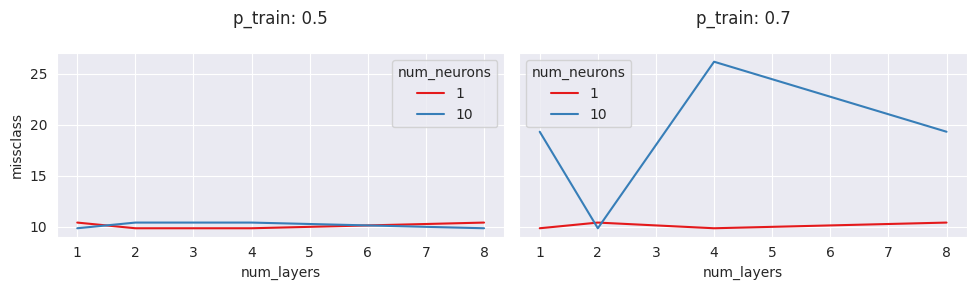

 -> duracion Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png
: 0.29s
Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png


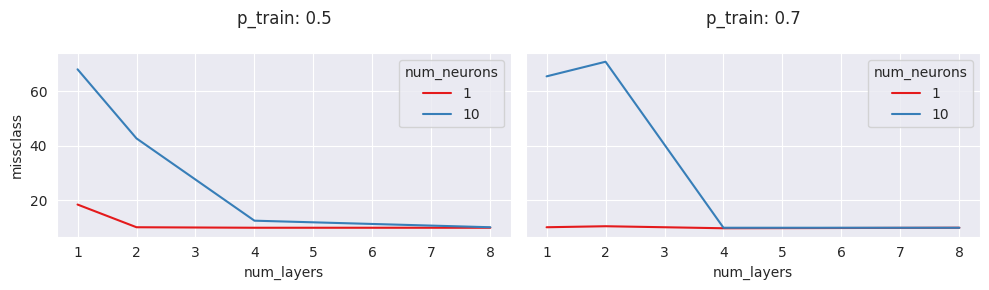

 -> duracion Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png
: 0.25s


['/home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationrelu.png',
 '/home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_lineplot_paletteSet1_missclass_vs_num_layers_by_num_neurons_activationtanh.png']

In [50]:
import seaborn as sns
from PerplexityLab.miscellaneous import NamedPartial
from PerplexityLab.visualization import generic_plot

generic_plot(
    data_manager=dm, 
    x="num_layers", 
    y="missclass", 
    label="num_neurons", 
    missclass=lambda missclassification_error: np.mean(missclassification_error)*100, 
    plot_func=NamedPartial(sns.lineplot, palette="Set1"),
    train=["run_nn_loop"],
    axes_by=["p_train"],
    plot_by=["activation"],
    savefig=False,
    axes_xy_proportions=(5, 3)
)

### Customized plots

But if you need more complex plots and still keep the aforementioned facilities, just add a decorator to your definition.
* Just define your plot as depending on some of the variables (parameters, inputs or outputs) of your project experiments and the perplex_plot will know how to retrieve them.
* Plots will be saved in the right folders
* You can still filter by other variables, plot axes and different plots

Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_digit_.png


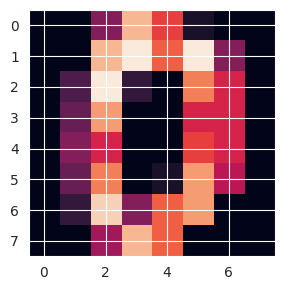

 -> duracion Plot /home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_digit_.png
: 0.13s


['/home/callum/Repos/GitHub/PerplexityLab/src/examples/MLLab/plot_digit_.png']

In [59]:
from PerplexityLab.visualization import perplex_plot

@perplex_plot
def plot_digit(fig, ax, X, i):
    # Any variable obtained from the dataset will be a list even if it holds only one element.
    # that's why we have to get X[0] before reshaping.
    ax.imshow(X[0][i].reshape((8, 8)))
               
plot_digit(
    data_manager=dm,
    i=0,
    axes_by=[],
    plot_by=[],
    savefig=False,
    axes_xy_proportions=(5, 3)
)

### Indexing

The information about the experiments is saved but can be retrieved easily and converted to dataframe for further analysis.
* If only one variable is called: a list wil be returned
* If a list of variables: a dictionary with a list of values each and the index is associated with the same experiment (all is properly sorted)

In [89]:
import pandas as pd
pd.DataFrame.from_dict(dm[["num_neurons","num_layers", "train"]])

,num_neurons,num_layers,train
0,1,8,run_nn_loop
1,1,8,baseline
2,10,8,run_nn_loop
3,10,8,baseline
4,1,1,run_nn_loop
...,...,...,...
59,10,2,baseline
60,1,4,run_nn_loop
61,1,4,baseline
62,10,4,run_nn_loop


If we just want to get everything

In [90]:
from PerplexityLab.DataManager import ALL

pd.DataFrame.from_dict(dm[ALL])

,coefs,intercepts_,seed,p_train,activation,y,analysis,num_layers,p_test,missclassification_error,dataset_name,X,num_neurons,preprocessing,predictions,train
0,"[[[5.108665391751808e-06], [-1.089115662522342...","[[-0.741706124512739], [-0.3042907243929462], ...",42,0.5,tanh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,8,0.3,"[False, False, True, False, False, False, Fals...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",1,create_dataset,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",run_nn_loop
1,None,None,42,0.5,tanh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,8,0.3,"[True, True, True, True, True, True, False, Tr...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",1,create_dataset,"[0, 5, 3, 6, 9, 6, 5, 7, 5, 4, 4, 7, 2, 2, 2, ...",baseline
2,"[[[-4.3811242424143325e-05, -6.696346769238465...","[[-0.8732018184490928, -0.7033923480602225, -0...",42,0.5,tanh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,8,0.3,"[False, False, False, False, False, False, Fal...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",10,create_dataset,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",run_nn_loop
3,None,None,42,0.5,tanh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,8,0.3,"[True, True, True, True, True, True, False, Tr...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",10,create_dataset,"[0, 5, 3, 6, 9, 6, 5, 7, 5, 4, 4, 7, 2, 2, 2, ...",baseline
4,"[[[-1.2340696085949562e-09], [-1.1459208950179...","[[-0.16339671587072038], [-0.3851409458667783,...",42,0.5,tanh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,1,0.3,"[False, False, True, True, False, True, False,...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",1,create_dataset,"[6, 3, 3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 6, 6, 6, ...",run_nn_loop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,None,None,42,0.7,relu,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,2,0.3,"[True, True, True, True, True, True, False, Tr...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",10,create_dataset,"[0, 5, 3, 6, 9, 6, 5, 7, 5, 4, 4, 7, 2, 2, 2, ...",baseline
60,"[[[-0.000351618521827487], [-1.841894588760690...","[[-0.1331137476054451], [-1.2438749722217657],...",42,0.7,relu,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,4,0.3,"[False, False, True, False, False, False, Fals...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",1,create_dataset,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",run_nn_loop
61,None,None,42,0.7,relu,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,4,0.3,"[True, True, True, True, True, True, False, Tr...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",1,create_dataset,"[0, 5, 3, 6, 9, 6, 5, 7, 5, 4, 4, 7, 2, 2, 2, ...",baseline
62,"[[[0.0001095004301662234, 1.1182264793368504e-...","[[-0.45697182534616243, 0.15051390255587138, -...",42,0.7,relu,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, ...",calculate_errors,4,0.3,"[False, False, True, True, False, True, False,...",digits,"[[0.0, 0.0, 5.0, 13.0, 9.0, 1.0, 0.0, 0.0, 0.0...",10,create_dataset,"[3, 3, 3, 6, 3, 6, 3, 3, 3, 6, 4, 6, 3, 3, 3, ...",run_nn_loop


We can apply some function to our dataset before retrieving the information
* The functions should depend on variables of the project

In [78]:
from PerplexityLab.DataManager import apply
pd.DataFrame.from_dict(apply(dm, names=["num_neurons","num_layers", "train"], 
                             error=lambda missclassification_error: np.mean(missclassification_error)))

,error,num_neurons,num_layers,train
0,0.098330,1,8,run_nn_loop
1,0.855288,1,8,baseline
2,0.100186,10,8,run_nn_loop
3,0.855288,10,8,baseline
4,0.183673,1,1,run_nn_loop
...,...,...,...,...
59,0.873840,10,2,baseline
60,0.098330,1,4,run_nn_loop
61,0.873840,1,4,baseline
62,0.261596,10,4,run_nn_loop


We can filter, as we did for plotting

In [81]:
from PerplexityLab.DataManager import dmfilter
pd.DataFrame.from_dict(dmfilter(dm, names=["num_neurons","num_layers", "train"], num_neurons=[10]))

,num_neurons,num_layers,train
0,10,8,run_nn_loop
1,10,8,baseline
2,10,1,run_nn_loop
3,10,1,baseline
4,10,2,run_nn_loop
5,10,2,baseline
6,10,4,run_nn_loop
7,10,4,baseline
8,10,8,run_nn_loop
9,10,8,baseline


We can also group by while filtering

In [88]:
from PerplexityLab.DataManager import group
for g, gdm in group(dm, names=["num_neurons","num_layers", "train"], by=["train"], num_neurons=[10]):
    print(g)
    print(pd.DataFrame.from_dict(gdm))
    print("-----------------------")

OrderedDict([('train', 'baseline')])
    num_neurons  num_layers     train
0            10           8  baseline
1            10           1  baseline
2            10           2  baseline
3            10           4  baseline
4            10           8  baseline
5            10           1  baseline
6            10           2  baseline
7            10           4  baseline
8            10           8  baseline
9            10           1  baseline
10           10           2  baseline
11           10           4  baseline
12           10           8  baseline
13           10           1  baseline
14           10           2  baseline
15           10           4  baseline
-----------------------
OrderedDict([('train', 'run_nn_loop')])
    num_neurons  num_layers        train
0            10           8  run_nn_loop
1            10           1  run_nn_loop
2            10           2  run_nn_loop
3            10           4  run_nn_loop
4            10           8  run_nn_loop
5      

### CO2 and Energy consumption information

In [10]:
print("The approximated CO2 produced during this experiments was: ", dm.CO2kg, "kg")
print("The approximated energy consumption during this experiments was: ", dm.electricity_consumption_kWh, "kWh")
print("The approximated computation time spent during this experiments was: ", dm.computation_time_s/60, "m")

The approximated CO2 produced during this experiments was:  1.4501005058359893e-06 kg
The approximated energy consumption during this experiments was:  2.14734267116243e-05 kWh
The approximated computation time spent during this experiments was:  0.09396501779556274 m


For more detailed information about the consumption and time spent in each processing layer or plotting you can access directly to the DataFrame grouped by experiment or layer.

In [11]:
dm.get_emissions_summary(group_by_experiment=True, group_by_layer=True)

duration(s)  power_consumption(kWh)  \
experiment computation_layer                                        
MLLab      analysis              0.319086                0.000001   
           figures               0.869542                0.000003   
           preprocessing         0.338305                0.000001   
           train                 4.110968                0.000016   

                              CO2_emissions(kg)  
experiment computation_layer                     
MLLab      analysis                7.979689e-08  
           figures                 2.107997e-07  
           preprocessing           8.257290e-08  
           train                   1.076931e-06